<a href="https://colab.research.google.com/github/arisnbrio/covid-19-country-infection-levels/blob/main/CountryClassificationLog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Datasets and merge together into one dataset by key values 

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly --upgrade

epid = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv", parse_dates = True)
# deceased, deaths, recover etc
demo = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/demographics.csv")
# population
ind = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/index.csv")

eco = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/economy.csv")

geo = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/geography.csv")
# needed for country/country code/subregion1_code(city)


data = epid.merge(demo,on='key').merge(ind,on='key').merge(eco,on='key').merge(geo,on='key')

cases_per_100T = data['new_confirmed']/data['population'] # cases per 1 million pop
cases_per_100T = cases_per_100T.apply(lambda x: x*100000)
data = data.assign(cases_per_100T = cases_per_100T)

# Data Cleaning/Exploratary Data Analysis




In [2]:
# info about entire dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153133 entries, 0 to 153132
Data columns (total 55 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   date                         153133 non-null  object 
 1   key                          152681 non-null  object 
 2   new_confirmed                153016 non-null  float64
 3   new_deceased                 142188 non-null  float64
 4   new_recovered                31440 non-null   float64
 5   new_tested                   52802 non-null   float64
 6   total_confirmed              153061 non-null  float64
 7   total_deceased               142489 non-null  float64
 8   total_recovered              30571 non-null   float64
 9   total_tested                 53139 non-null   float64
 10  population                   153133 non-null  float64
 11  population_male              152227 non-null  float64
 12  population_female            152227 non-null  float64
 13 

In [3]:
# number of days of observations we have for each country
num_days = data['date'].nunique()
num_days

456

## Taking only the data from Jan 2021 and Feb 2021 to reduce the amount of data we are working with

In [4]:
country_data = data[data['subregion1_code'].isnull()] # collect rows that don't specify subregions
country_data = country_data[(country_data['date'] >= '2021-01-01') & (country_data['date'] <= '2021-02-28')] # filter dates between jan and feb
country_data = country_data.drop(['subregion1_code','subregion1_name','subregion2_code','subregion2_name'], axis=1) # drop column
country_data=country_data[["date","country_name","cases_per_100T","new_confirmed", "new_deceased","population","population_density","gdp_per_capita"]]
country_data.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 11921 entries, 367 to 113280
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                11921 non-null  object 
 1   country_name        11921 non-null  object 
 2   cases_per_100T      11921 non-null  float64
 3   new_confirmed       11921 non-null  float64
 4   new_deceased        11921 non-null  float64
 5   population          11921 non-null  float64
 6   population_density  11921 non-null  float64
 7   gdp_per_capita      11921 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 838.2+ KB


## Now let's take a look at the correlation matrix of all variables in the data subset we are working with to see if we have a problem with multicollinearity
Since the Pearson method relies on the assumption of the data being normally distributed, we use the Spearman method instead because it doesn't have assumptions of the population distribution of the data, so it generalizes to our dataset better. 

In [5]:
corrMatrix = country_data.corr(method = 'spearman')
print(corrMatrix)

                    cases_per_100T  ...  gdp_per_capita
cases_per_100T             1.00000  ...         0.45841
new_confirmed              0.78593  ...         0.24029
new_deceased               0.63938  ...         0.18181
population                 0.06896  ...        -0.29946
population_density        -0.25544  ...        -0.20348
gdp_per_capita             0.45841  ...         1.00000

[6 rows x 6 columns]


## Visualize the correlation matrix with a heatmap

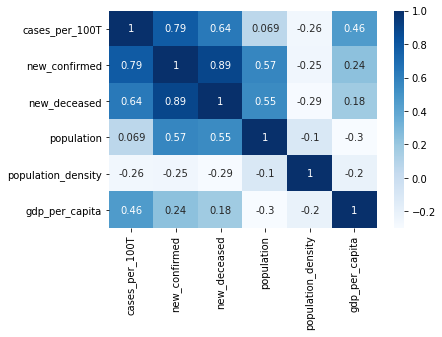

In [6]:
sns.heatmap(corrMatrix, annot = True, cmap = 'Blues')
plt.show()

                     cases_per_100T  ...      gdp_per_capita
cases_per_100T            408.50161  ...        146697.65111
new_confirmed           61504.13969  ...      39575583.08551
new_deceased             1042.01429  ...        806596.92338
population         -184943392.37570  ... -236798757206.62366
population_density    3741984.17204  ...   24789402267.63024
gdp_per_capita         146697.65111  ...     689430612.06290

[6 rows x 6 columns]


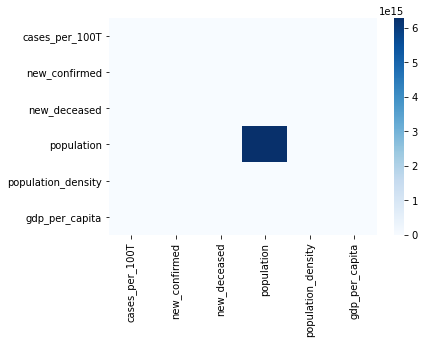

In [7]:
covMatrix = pd.DataFrame.cov(country_data)
print(covMatrix)
sns.heatmap(covMatrix, annot = False, cmap = 'Blues', robust = True)
plt.show()

## Split into Months 
Using January data as our training set, and February data as our test set. CDC recognizes infection severity levels by the last 28 days which is roughly a month so we use these constraints to determine our levels for the months of January and February. We then summarize our data to get our CDC levels.

In [8]:
jan_data = country_data[(country_data['date'] >= '2021-01-01') & (country_data['date'] < '2021-02-01')]

jan_data = jan_data.groupby(
   ['country_name']
).agg(
    {   'cases_per_100T': ['sum'], # sum of total new cases in the time span per 1M ppl
        'new_confirmed':['sum'],   # cumulative number of cases over the past 59 days 
        'population': ['mean'],
        'population_density': ['mean'],
        'new_deceased': ['sum'],
        'gdp_per_capita': ['mean']
    }
).reset_index()



conditions = [  # if else basically
    (jan_data['cases_per_100T'] < 5), # low
    (jan_data['cases_per_100T'] >= 5) & (jan_data['cases_per_100T'] <= 50), # medium
    (jan_data['cases_per_100T'] > 50) & (jan_data['cases_per_100T'] <= 100), # high
    (jan_data['cases_per_100T'] > 100) # extreme
    ]
values = ['low', 'moderate', 'high', 'extreme']

## true labels for our training data
jan_data['levels'] = np.select(conditions, values)

jan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (country_name, )            203 non-null    object 
 1   (cases_per_100T, sum)       203 non-null    float64
 2   (new_confirmed, sum)        203 non-null    float64
 3   (population, mean)          203 non-null    float64
 4   (population_density, mean)  203 non-null    float64
 5   (new_deceased, sum)         203 non-null    float64
 6   (gdp_per_capita, mean)      203 non-null    int64  
 7   (levels, )                  203 non-null    object 
dtypes: float64(5), int64(1), object(2)
memory usage: 12.8+ KB


In [9]:
feb_data = country_data[(country_data['date'] >= '2021-02-01') & (country_data['date'] <= '2021-02-28')]

feb_data = feb_data.groupby(
   ['country_name']
).agg(
    {   'cases_per_100T': ['sum'], # sum of total new cases in the time span per 1M ppl
        'new_confirmed':['sum'],   # cumulative number of cases over the past 59 days 
        'population': ['mean'],
        'population_density': ['mean'],
        'new_deceased': ['sum'],
        'gdp_per_capita': ['mean']
    }
).reset_index()


conditions = [  # if else basically
    (feb_data['cases_per_100T'] < 5), # low
    (feb_data['cases_per_100T'] >= 5) & (feb_data['cases_per_100T'] <= 50), # medium
    (feb_data['cases_per_100T'] > 50) & (feb_data['cases_per_100T'] <= 100), # high
    (feb_data['cases_per_100T'] > 100) # extreme
    ]
values = ['low', 'moderate', 'high', 'extreme']

## true labels for our training data
feb_data['levels'] = np.select(conditions, values)

feb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (country_name, )            202 non-null    object 
 1   (cases_per_100T, sum)       202 non-null    float64
 2   (new_confirmed, sum)        202 non-null    float64
 3   (population, mean)          202 non-null    float64
 4   (population_density, mean)  202 non-null    float64
 5   (new_deceased, sum)         202 non-null    float64
 6   (gdp_per_capita, mean)      202 non-null    int64  
 7   (levels, )                  202 non-null    object 
dtypes: float64(5), int64(1), object(2)
memory usage: 12.8+ KB


## Uneven Dimensions Most Likely Due to Missing country_name in February Data

In [10]:
# Finding missing country from February data
jan_data.loc[~jan_data.country_name.isin(feb_data['country_name'])]

,country_name,cases_per_100T,new_confirmed,population,population_density,new_deceased,gdp_per_capita,levels
,,sum,sum,mean,mean,sum,mean,
107,Macau,0.15400,1.00000,649342.00000,21717124.00000,0.00000,84096,low


In [11]:

jan_data = jan_data[jan_data.country_name != 'Macau']
print('Shape of January Data:', jan_data.shape)
print('Shape of February Data:', feb_data.shape)
# removing Macau so that dimensions match

Shape of January Data: (202, 8)
Shape of February Data: (202, 8)


## Infection Levels for January and February

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


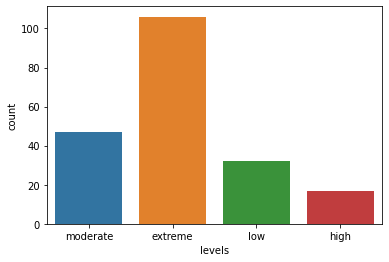

In [12]:
import seaborn as sns
sns.countplot(jan_data['levels'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


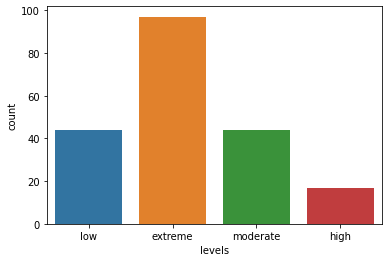

In [13]:
sns.countplot(feb_data['levels'])

## Training set

Turning country_name into a dummy variable since it is categorical

In [14]:

train_X = jan_data.drop(['levels'], axis = 1)
train_X['population_density'].fillna((feb_data['population_density'].mean()), inplace=True)
train_X

country_name=pd.get_dummies(train_X['country_name'],drop_first=True)
train_X.drop(['country_name'],axis=1,inplace=True)
train_X = pd.concat([train_X,country_name],axis=1)
train_X.info()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 202 entries, 0 to 202
Columns: 207 entries, ('cases_per_100T', 'sum') to Zimbabwe
dtypes: float64(5), int64(1), uint8(201)
memory usage: 60.7 KB


## Transforming Categorical Into Numerical (Train)

In [15]:
from sklearn import preprocessing
num=preprocessing.LabelEncoder()
num.fit(jan_data['levels'])
jan_data['levels']=num.transform(jan_data['levels'])
train_Y=jan_data['levels'] # checking transformation from categorical > numerical

## Testing Set

Turning country_name into a dummy variable since it is categorical

In [16]:
import statistics

test_X = feb_data.drop(['levels'],axis = 1).fillna(0)
test_X['population_density'].fillna((feb_data['population_density'].mean()), inplace=True)

country_name=pd.get_dummies(test_X['country_name'],drop_first=True)
test_X.drop(['country_name'],axis=1,inplace=True)
test_X=pd.concat([test_X,country_name],axis=1)
test_X.info()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Columns: 207 entries, ('cases_per_100T', 'sum') to Zimbabwe
dtypes: float64(5), int64(1), uint8(201)
memory usage: 49.2 KB


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Transforming Categorical Into Numerical (Test)

In [17]:
num.fit(feb_data['levels'])
feb_data['levels']=num.transform(feb_data['levels'])
test_Y=feb_data['levels'] # checking transformation from categorical > numerical
test_Y

0      2
1      0
2      3
3      2
4      0
      ..
197    2
198    2
199    2
200    0
201    3
Name: levels, Length: 202, dtype: int64

In [18]:
jan_data.head()


,country_name,cases_per_100T,new_confirmed,population,population_density,new_deceased,gdp_per_capita,levels
,,sum,sum,mean,mean,sum,mean,
0,Afghanistan,6.51197,2535.00000,38928341.00000,59627.00000,194.00000,502,3
1,Albania,708.10539,20269.00000,2862427.00000,99.60000,207.00000,5352,0
2,Algeria,18.17061,7968.00000,43851043.00000,18411.00000,138.00000,3948,3
3,American Samoa,0.00000,0.00000,55196.00000,275985.00000,0.00000,11466,2
4,Andorra,2400.82832,1855.00000,77265.00000,164394.00000,17.00000,40886,0


In [19]:
feb_data.head()

,country_name,cases_per_100T,new_confirmed,population,population_density,new_deceased,gdp_per_capita,levels
,,sum,sum,mean,mean,sum,mean,
0,Afghanistan,1.63891,638.00000,38928341.00000,59627.00000,41.00000,502,2
1,Albania,1010.99521,28939.00000,2862427.00000,99.60000,423.00000,5352,0
2,Algeria,12.94610,5677.00000,43851043.00000,18411.00000,93.00000,3948,3
3,American Samoa,0.00000,0.00000,55196.00000,275985.00000,0.00000,11466,2
4,Andorra,1186.82456,917.00000,77265.00000,164394.00000,9.00000,40886,0


After checking dataframe for jan_data and feb_data, our levels converted into

*   3 = moderate
*   0 = extreme
*   2 = low
*   1 = high





## Oversampling

Since there is class imbalance, we use the SMOTEEN package to oversample.

In [20]:
train_Y.value_counts()

0    106
3     47
2     32
1     17
Name: levels, dtype: int64

In [21]:
from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


length of oversampled data is  424
Number of countries level low in oversampled data 106
Number of countries level moderate in oversampled data 106
Number of countries level high in oversampled data 106
Number of countries level extreme in oversampled data 106


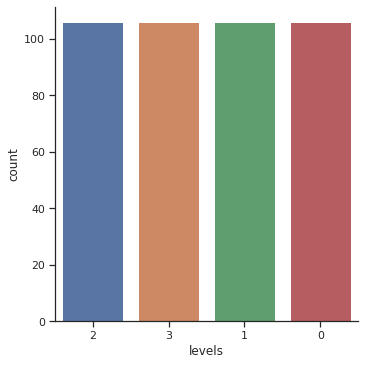

In [22]:

os = SMOTE(random_state=0)
columns = train_X.columns
os_data_X,os_data_y=os.fit_sample(train_X, train_Y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y = pd.DataFrame(data=os_data_y,columns=['levels'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of countries level low in oversampled data",len(os_data_y[os_data_y['levels']==2]))
print("Number of countries level moderate in oversampled data",len(os_data_y[os_data_y['levels']==3]))
print("Number of countries level high in oversampled data",len(os_data_y[os_data_y['levels']==1]))
print("Number of countries level extreme in oversampled data",len(os_data_y[os_data_y['levels']==0]))

sns.set_theme(style="ticks")
sns.color_palette("husl", 4)
y_os = sns.catplot(x = "levels", kind = "count", data = os_data_y, order = [2, 3, 1, 0])


## OVR Logistic Regression

Regular Logistic Regression is for binary responses which is why we opt for different variants of logistic regression for multi-classification.



In [23]:
from sklearn.linear_model import LogisticRegression
logmod_ovr = LogisticRegression(multi_class='ovr',max_iter=1000).fit(os_data_X, os_data_y.values.ravel())

In [24]:
# accuracy for both training and testing sets to check for signs of overfitting
print('OVR Logistic Regression Accuracy (Training):', logmod_ovr.score(train_X, train_Y)) # accuracy
print('OVR Logistic Regression Accuracy (Testing):', logmod_ovr.score(test_X, test_Y)) # accuracy

OVR Logistic Regression Accuracy (Training): 0.8910891089108911
OVR Logistic Regression Accuracy (Testing): 0.8861386138613861


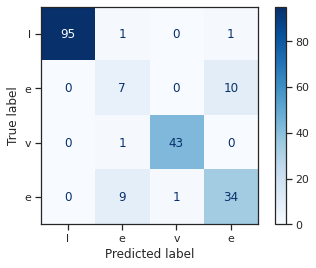

In [25]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


ovrdisp = plot_confusion_matrix(logmod_ovr, test_X, test_Y,
                                 display_labels='levels',
                                 cmap=plt.cm.Blues)
plt.show()

In [26]:
import sklearn.metrics as metrics
import plotly.figure_factory as ff
print(metrics.classification_report(test_Y, logmod_ovr.predict(test_X))) # classification report



              precision    recall  f1-score   support

           0       1.00      0.98      0.99        97
           1       0.39      0.41      0.40        17
           2       0.98      0.98      0.98        44
           3       0.76      0.77      0.76        44

    accuracy                           0.89       202
   macro avg       0.78      0.79      0.78       202
weighted avg       0.89      0.89      0.89       202



## Multinomial Logistic Regression

In [27]:
logmod_multi = LogisticRegression(multi_class='multinomial',
    solver='lbfgs',max_iter=10000).fit(os_data_X, os_data_y.values.ravel())

In [28]:
print('Multinomial Logistic Regression Accuracy (Training):', logmod_multi.score(train_X, train_Y)) 
print('Multinomial Logistic Regression Accuracy (Testing):', logmod_multi.score(test_X, test_Y)) 


Multinomial Logistic Regression Accuracy (Training): 0.995049504950495
Multinomial Logistic Regression Accuracy (Testing): 0.9702970297029703


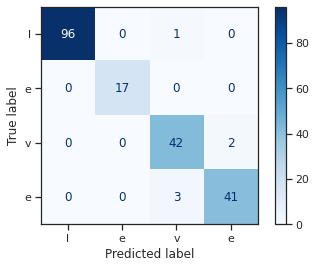

In [29]:
multidisp = plot_confusion_matrix(logmod_multi, test_X, test_Y,
                                 display_labels='levels',
                                 cmap=plt.cm.Blues)
plt.show()

In [30]:
print(metrics.classification_report(test_Y, logmod_multi.predict(test_X)))# classification report



              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       1.00      1.00      1.00        17
           2       0.91      0.95      0.93        44
           3       0.95      0.93      0.94        44

    accuracy                           0.97       202
   macro avg       0.97      0.97      0.97       202
weighted avg       0.97      0.97      0.97       202



## Ordinal Logistic Regression

In [31]:
!pip install mord
from mord import LogisticAT
ord = LogisticAT(alpha=0)
ord.fit(os_data_X,os_data_y.values.ravel())
ord_y = ord.predict(test_X)
ord_ytrain = ord.predict(train_X)
print('Multinomial Logistic Regression Accuracy (Training):',(metrics.accuracy_score(train_Y, np.round(ord_ytrain)))) # accuracy
print('Multinomial Logistic Regression Accuracy (Testing):',(metrics.accuracy_score(test_Y, np.round(ord_y))))


Multinomial Logistic Regression Accuracy (Training): 0.6188118811881188
Multinomial Logistic Regression Accuracy (Testing): 0.594059405940594


In [32]:
metrics.confusion_matrix(test_Y,ord_y) # confusion matrix

array([[94,  1,  1,  1],
       [10,  3,  3,  1],
       [ 0, 26, 12,  6],
       [ 6, 17, 10, 11]])

In [33]:
print(metrics.classification_report(test_Y, ord.predict(test_X))) # classification report

              precision    recall  f1-score   support

           0       0.85      0.97      0.91        97
           1       0.06      0.18      0.09        17
           2       0.46      0.27      0.34        44
           3       0.58      0.25      0.35        44

    accuracy                           0.59       202
   macro avg       0.49      0.42      0.42       202
weighted avg       0.64      0.59      0.59       202



## Multiclass Logistic Regression with Built in Cross Validation

In [34]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
clf = LogisticRegressionCV(cv = 10, random_state = 0, penalty = 'l2', solver = 'newton-cg', max_iter = 1000)
clf.fit(os_data_X, os_data_y.values.ravel())
clf_pred = clf.predict(test_X)

In [35]:
print('Multiclass Logistic Regression with Built in Cross Validation (Training):', clf.score(train_X, train_Y)) 
print('Multiclass Logistic Regression with Built in Cross Validation (Testing):', clf.score(test_X, test_Y)) 

Multiclass Logistic Regression with Built in Cross Validation (Training): 1.0
Multiclass Logistic Regression with Built in Cross Validation (Testing): 0.9851485148514851


In [36]:
print(metrics.classification_report(test_Y, clf_pred)) # classification report

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        97
           1       0.94      1.00      0.97        17
           2       1.00      0.95      0.98        44
           3       0.96      1.00      0.98        44

    accuracy                           0.99       202
   macro avg       0.98      0.99      0.98       202
weighted avg       0.99      0.99      0.99       202



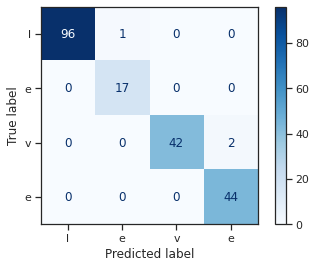

In [37]:
logcv_disp = plot_confusion_matrix(clf, test_X, test_Y,
                                 display_labels='levels',
                                 cmap=plt.cm.Blues)
plt.show()

## SVM - RBF

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#fit the model
rbf_SVM = SVC(kernel='rbf', C=1E7, decision_function_shape='ovo',probability=True)
rbf_SVM.fit(os_data_X,os_data_y)
rbf_pred=rbf_SVM.predict(test_X)

In [39]:
print('SVM RBF Accuracy (Training):', rbf_SVM.score(train_X, train_Y)) 
print('SVM RBF Accuracy  (Testing):', rbf_SVM.score(test_X, test_Y)) 

SVM RBF Accuracy (Training): 0.7277227722772277
SVM RBF Accuracy  (Testing): 0.6534653465346535


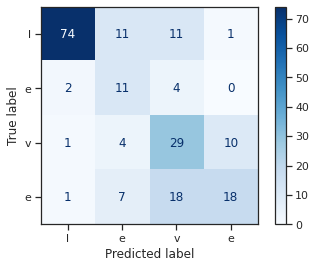

In [40]:
svmrbf_disp = plot_confusion_matrix(rbf_SVM, test_X, test_Y,
                                 display_labels='levels',
                                 cmap=plt.cm.Blues)

In [41]:

print(metrics.classification_report(test_Y, rbf_pred)) # classification report

              precision    recall  f1-score   support

           0       0.95      0.76      0.85        97
           1       0.33      0.65      0.44        17
           2       0.47      0.66      0.55        44
           3       0.62      0.41      0.49        44

    accuracy                           0.65       202
   macro avg       0.59      0.62      0.58       202
weighted avg       0.72      0.65      0.67       202



## Model Selection/Conclusion

Out of all the logistic regression variants we have tried, the best accuracy, classification matrix, and classification report is Multinomial Logistic Regression and the multiclass logistic regression with cross validation model. These two are pretty close in performance with Multiclass Logistic Regression CV having slightly better performance in these measures.

In [42]:
print('OVR Logistic Regression Accuracy:', np.round(logmod_ovr.score(test_X, test_Y)*100))
print('Multinomial Logistic Regression Accuracy:', np.round(logmod_multi.score(test_X, test_Y)*100))
print('Ordinal Logistic Regression Accuracy:', np.round(metrics.accuracy_score(test_Y, np.round(ord_y))*100))
print('Multiclass Logistic Regression CV Accuracy:', np.round(accuracy_score(test_Y, clf_pred)*100))
print('SVM RBF Accuracy:', np.round(accuracy_score(test_Y, rbf_pred)*100))

OVR Logistic Regression Accuracy: 89.0
Multinomial Logistic Regression Accuracy: 97.0
Ordinal Logistic Regression Accuracy: 59.0
Multiclass Logistic Regression CV Accuracy: 99.0
SVM RBF Accuracy: 65.0
